In [80]:
import pandas as pd
import numpy as np
import os


In [81]:
pd.set_option('display.max_columns', None)

# Read datasets from the interim directory
X_train = pd.read_pickle("../../data/interim/X_train_binary.pkl")
X_val = pd.read_pickle("../../data/interim/X_val_binary.pkl")
X_test = pd.read_pickle("../../data/interim/X_test_binary.pkl")
y_train = pd.read_pickle("../../data/interim/y_train_binary.pkl")
y_val = pd.read_pickle("../../data/interim/y_val_binary.pkl")
y_test = pd.read_pickle("../../data/interim/y_test_binary.pkl")

In [82]:
X_train

,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z,azimuth,pitch,roll
634004,-0.458843,-0.004343,-0.272226,0.032586,-0.057479,0.017799,0.151812,-0.795093,-1.048645
634005,-0.881271,0.789259,-0.322166,0.031217,-0.012802,-0.002940,0.136114,-0.778771,-0.997640
634006,-0.750800,0.547177,-0.330515,0.042022,0.011359,-0.011404,0.121327,-0.765772,-0.956557
634007,-0.640295,0.394234,-0.315634,0.030857,0.012073,-0.015476,0.108499,-0.754728,-0.921267
634008,-0.686538,0.550332,-0.359439,0.009593,0.003928,-0.010498,0.098456,-0.744377,-0.889684
...,...,...,...,...,...,...,...,...,...
109057760,0.450731,0.535045,-0.324386,-0.031796,-0.059572,-0.027028,-0.127635,-0.706084,0.517298
109057761,0.481948,0.536976,-0.334319,-0.016996,-0.046264,-0.028323,-0.126733,-0.705844,0.516299
109057762,0.502064,0.539007,-0.333029,0.000452,-0.029247,-0.023712,-0.126094,-0.706144,0.516886
109057763,0.498980,0.536931,-0.329682,0.008017,-0.019459,-0.027067,-0.125563,-0.706848,0.518772


In [83]:
y_test.value_counts()

fall_label
ADL     876147
FALL     19757
Name: count, dtype: int64

### Segment into Windows

In [1]:
def create_windows(X, y, window_size=400, overlap=0.5, positive_label="FALL"):
    """
    Slice X and y into sliding windows of length window_size, with given overlap.
    Label each window "FALL" if any sample in it is positive_label,
    otherwise "ADL".
    
    Arguments:
        X: array of shape (T, ...), your sensor data
        y: array of shape (T,), with string labels "FALL" or "ADL"
        window_size: number of timesteps per window
        overlap: fraction of overlap between consecutive windows (0.0–1.0)
        positive_label: label in y to treat as the “anomaly” class
    
    Returns:
        X_windows: array of shape (n_windows, window_size, ...)
        y_windows: array of shape (n_windows,) with values "FALL" or "ADL"
    """
    X_windows, y_windows = [], []
    # compute step size (e.g. 50% overlap → step_size = window_size // 2)
    step_size = int(window_size * (1 - overlap))

    for start in range(0, len(X) - window_size + 1, step_size):
        end = start + window_size
        win_X = X[start:end]
        win_y = y[start:end]

        # any-positive labeling
        if np.any(win_y == positive_label):
            label = positive_label
        else:
            # default to the other class—for example "ADL"
            label = "ADL" if positive_label == "FALL" else "FALL"

        X_windows.append(win_X)
        y_windows.append(label)

    return np.array(X_windows), np.array(y_windows)


In [2]:
X_train_windows, y_train_windows = create_windows(X_train, y_train)
X_val_windows, y_val_windows = create_windows(X_val, y_val)
X_test_windows, y_test_windows = create_windows(X_test, y_test)

NameError: name 'X_train' is not defined

In [128]:
X_train_windows.shape

(13906, 400, 9)

In [129]:
y_train_windows.shape

(13906,)

### Encode Label

In [130]:
label_map = {'ADL': 0, 'FALL': 1}
y_train_windows_encoded = np.vectorize(label_map.get)(y_train_windows)
y_val_windows_encoded = np.vectorize(label_map.get)(y_val_windows)
y_test_windows_encoded = np.vectorize(label_map.get)(y_test_windows)

In [131]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv1D, MaxPooling1D,
                                     GlobalAveragePooling1D,
                                     BatchNormalization, Dropout,
                                     Dense)


input_shape = (X_train_windows.shape[1], X_train_windows.shape[2])  

# LoS = length of segment (timesteps)
# input_shape = (LoS, 3)
# num_classes = len(label_map)

model = Sequential([
    # ——— Feature extractor for one stream (e.g. accelerometer or gyro) ———
    Conv1D(64, kernel_size=3, strides=1, activation='relu',
           input_shape=input_shape),
    MaxPooling1D(pool_size=2),

    Conv1D(64, kernel_size=3, strides=1, activation='relu'),
    MaxPooling1D(pool_size=2),

    Conv1D(64, kernel_size=3, strides=1),      # no activation/pool here
    GlobalAveragePooling1D(),                  # → 64-D global feature

    # ——— Classification head ———
    BatchNormalization(),
    Dropout(0.5),
    Dense(len(label_map), activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


c:\Users\sovan\Desktop\Fall Detection\fresh-ilab-fall-detection\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [132]:
from sklearn.utils import class_weight

In [133]:
# Compute class weights to handle imbalance
y_train_array = np.array(y_train_windows_encoded)
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_array),
    y=y_train_array
)
class_weights = dict(enumerate(class_weights))


In [134]:
history = model.fit(
    X_train_windows, y_train_windows_encoded,
    validation_data=(X_val_windows, y_val_windows_encoded),
    epochs=20,
    batch_size=32,
    class_weight= class_weights
)

Epoch 1/20
435/435 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.7285 - loss: 0.5727 - val_accuracy: 0.8438 - val_loss: 0.4915
Epoch 2/20
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8680 - loss: 0.3216 - val_accuracy: 0.6250 - val_loss: 1.0618
Epoch 3/20
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8932 - loss: 0.2630 - val_accuracy: 0.8559 - val_loss: 0.4556
Epoch 4/20
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.8930 - loss: 0.2531 - val_accuracy: 0.8385 - val_loss: 0.4899
Epoch 5/20
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9097 - loss: 0.2164 - val_accuracy: 0.8845 - val_loss: 0.3888
Epoch 6/20
435/435 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9099 - loss: 0.2181 - val_accuracy: 0.8485 - val_loss: 0.5559
Epoch 7/20
435/435 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9175 - loss: 0.2066 - val_accuracy: 0.8785 - val_loss: 0.4493
Epoch 8/20
435/435 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9268 - loss: 0.1884 - val_accu

In [135]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (confusion_matrix, classification_report, 
                             precision_score, recall_score, f1_score)

def evaluate_model(model, X_test, y_test, label_classes=None, plot_confusion_matrix=True, plot_roc=True):

    # Evaluate the model for loss and accuracy
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    print("Test Loss: {:.4f}".format(loss))
    print("Test Accuracy: {:.4f}".format(accuracy))

    # Generate prediction probabilities and predicted classes
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    if plot_confusion_matrix:
        plt.figure(figsize=(10, 8))
        if label_classes is None:
            label_classes = [str(i) for i in range(cm.shape[0])]
        sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', 
                    xticklabels=label_classes, yticklabels=label_classes)
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title("Confusion Matrix")
        plt.show()

    # Compute and print classification report
    report = classification_report(y_test, y_pred, target_names=label_classes)
    print("Classification Report:\n", report)

    # Compute weighted precision, recall, and F1 scores
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    print("Weighted Precision: {:.4f}".format(precision))
    print("Weighted Recall: {:.4f}".format(recall))
    print("Weighted F1 Score: {:.4f}".format(f1))

    metrics = {
        'loss': loss,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }

    return metrics

Test Loss: 0.3378
Test Accuracy: 0.9031
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


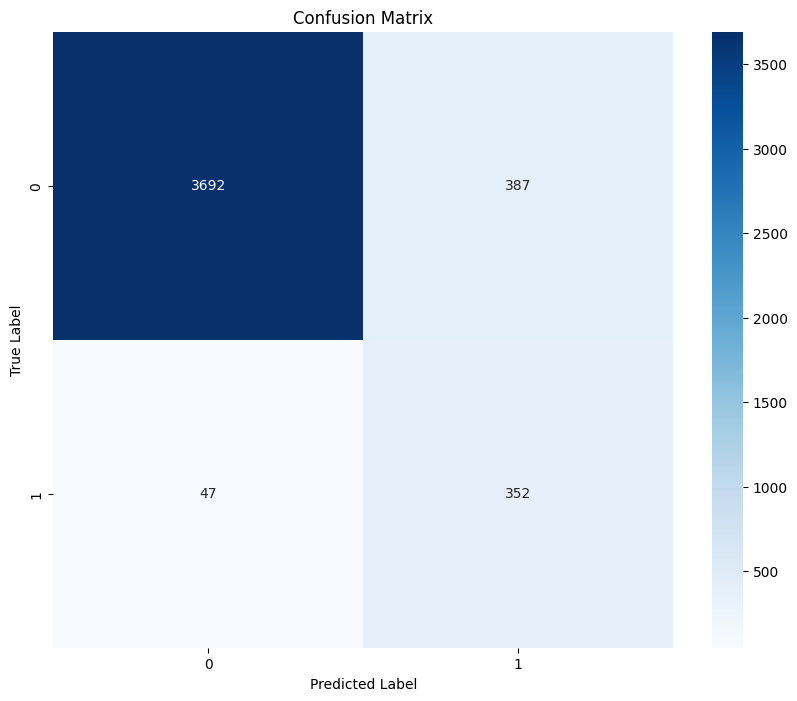

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.91      0.94      4079
           1       0.48      0.88      0.62       399

    accuracy                           0.90      4478
   macro avg       0.73      0.89      0.78      4478
weighted avg       0.94      0.90      0.92      4478

Weighted Precision: 0.9419
Weighted Recall: 0.9031
Weighted F1 Score: 0.9155


In [136]:
metrics = evaluate_model(model, X_test_windows, y_test_windows_encoded)


### 10-Fold Cross Validation

In [ ]:
from sklearn.model_selection import GroupKFold

In [ ]:
# Read datasets from the interim directory
df_filtered = pd.read_pickle("../../data/interim/df_filtered.pkl")

In [ ]:
from tensorflow.keras import Input

def build_model(input_shape, num_classes):
    model = Sequential([
        Input(shape=input_shape),
        Conv1D(64, 3, activation='relu'),
        Conv1D(128, 3, activation='relu'),
        MaxPooling1D(2),
        Conv1D(128, 3, activation='relu'),
        GlobalAveragePooling1D(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(1e-3),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
sensor_cols = ['acc_x','acc_y','acc_z','gyro_x','gyro_y','gyro_z']
groups     = df_filtered['subject_id'].values
gkf        = GroupKFold(n_splits=10)

val_losses     = []
val_accuracies = []

for fold, (train_idx, val_idx) in enumerate(
        gkf.split(df_filtered, df_filtered['label'], groups=groups)):

    # ----- 1) Select raw fold data -----
    df_tr = df_filtered.iloc[train_idx]
    df_va = df_filtered.iloc[val_idx]

    X_tr_raw = df_tr[sensor_cols].values
    y_tr_raw = df_tr['label'].values
    X_va_raw = df_va[sensor_cols].values
    y_va_raw = df_va['label'].values

    # ----- 2) Window -----
    X_train_windows, y_train_windows = create_windows(X_tr_raw, y_tr_raw,
                                                      window_size=50,
                                                      step_size=25)
    X_val_windows,   y_val_windows   = create_windows(X_va_raw, y_va_raw,
                                                      window_size=50,
                                                      step_size=25)

    # ----- 3) Encode labels -----
    le = LabelEncoder()
    y_train_encoded = le.fit_transform(y_train_windows)
    y_val_encoded   = le.transform(y_val_windows)

    # ----- 4) Build model -----
    input_shape = (X_train_windows.shape[1], X_train_windows.shape[2])  # (50,6)
    num_classes = len(le.classes_)

    model = build_model(input_shape, num_classes)
    

    # ----- 5) Train -----
    history = model.fit(
        X_train_windows, y_train_encoded,
        validation_data=(X_val_windows, y_val_encoded),
        epochs=25, batch_size=32, verbose=0
    )

    # ----- 6) Collect metrics -----
    val_loss = history.history['val_loss'][-1]
    val_acc  = history.history['val_accuracy'][-1]
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Fold {fold+1} — val_loss: {val_loss:.4f}, val_acc: {val_acc:.4%}")

# ----- 7) Aggregate across folds -----
mean_loss = np.mean(val_losses)
std_loss  = np.std(val_losses)
mean_acc  = np.mean(val_accuracies)
std_acc   = np.std(val_accuracies)

print("\n=== Cross‐Validation Results ===")
print(f"Val Loss: {mean_loss:.4f} ± {std_loss:.4f}")
print(f"Val Acc:  {mean_acc:.4%} ± {std_acc:.4%}")
